This script is dedicated to explore the departments (de: Ressort) with relation to the author mapping.

In [2]:
import json
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import networkx as nx
from dateutil import relativedelta
from datetime import datetime
import re
import tqdm
from src.models.MatchingType import MatchingType

In [3]:
con = sqlite3.connect('../data/interim/articles_with_author_mapping.db')
cur = con.cursor()

In [4]:
# get top 30 authors
rows = cur.execute('select abbreviation from unmapped_authors where matching_type = ? or matching_type = ? group by name order by count(*) desc limit 50', (MatchingType.DIRECT_MATCH.name, MatchingType.FUZZY_MATCH.name)).fetchall()
authors = [row[0] for row in rows]

In [5]:
# remove  None from authors
authors = [author for author in authors if author is not None]

In [6]:
authors

['joka',
 'nöß',
 'mape',
 'jhz',
 'lyn',
 'es',
 'mro',
 'luc',
 'boh',
 'agri',
 'maf',
 'chg',
 'cgr',
 'th',
 'ra',
 'cn',
 'ahr',
 'swd',
 'gap',
 'ts',
 'ic',
 'nf',
 'chl',
 'anzi',
 'okz',
 'cj',
 'sl',
 'maf',
 'ebu',
 'ap',
 'bro',
 'lcl',
 'joh',
 'kfm',
 'joh',
 'obü',
 'ttr',
 'aku',
 'rob',
 'mhs',
 'sie',
 'ala',
 'mey',
 'red',
 'art',
 'bm',
 'ka',
 'pm',
 'rohe',
 'sro']

In [7]:
json_authors = [json.dumps(author) for author in authors]

In [8]:
'(' + ','.join(json_authors) + ')'

'("joka","n\\u00f6\\u00df","mape","jhz","lyn","es","mro","luc","boh","agri","maf","chg","cgr","th","ra","cn","ahr","swd","gap","ts","ic","nf","chl","anzi","okz","cj","sl","maf","ebu","ap","bro","lcl","joh","kfm","joh","ob\\u00fc","ttr","aku","rob","mhs","sie","ala","mey","red","art","bm","ka","pm","rohe","sro")'

In [10]:
rows = cur.execute("SELECT ar.id, ar.article_namespace_array, ar.published_at, a.abbreviation FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.abbreviation in " + '(' + ','.join(json_authors) + ')').fetchall()

In [11]:
departments = pd.DataFrame(columns=['id', 'department', 'published_at', 'name'], data=rows)

In [12]:
departments

,id,department,published_at,name
0,1513,"[""Region"", ""Borna""]",2021-12-10T06:53:43+00:00,es
1,1515,"[""Region"", ""Borna""]",2021-12-10T07:01:28+00:00,es
2,1530,"[""Thema"", ""Specials"", ""Zoo-Leipzig"", ""Zoo-Nach...",2021-12-10T09:59:44+00:00,pm
3,1541,"[""Region"", ""Eilenburg""]",2021-12-10T11:43:25+00:00,ka
4,1626,"[""Region"", ""Borna""]",2021-12-09T09:49:38+00:00,es
...,...,...,...,...
20451,367465,"[""Region"", ""Delitzsch""]",2010-01-07T15:35:14+00:00,nf
20452,367521,"[""Leipzig"", ""Polizeiticker"", ""Polizeiticker-Le...",2010-01-06T15:16:44+00:00,maf
20453,367539,"[""Leipzig"", ""Lokales""]",2010-01-06T21:03:44+00:00,maf
20454,367635,"[""Leipzig"", ""Lokales""]",2010-01-04T15:25:21+00:00,maf


In [13]:
departments["department"] = departments["department"].apply(lambda x: json.loads(x))

In [14]:
departments = departments.explode('department')

In [15]:
# remove rows where department equals "Region" or "Nachrichten" for being to unspecific
departments = departments[departments.department != 'Region']
departments = departments[departments.department != 'Nachrichten']
departments

,id,department,published_at,name
0,1513,Borna,2021-12-10T06:53:43+00:00,es
1,1515,Borna,2021-12-10T07:01:28+00:00,es
2,1530,Thema,2021-12-10T09:59:44+00:00,pm
2,1530,Specials,2021-12-10T09:59:44+00:00,pm
2,1530,Zoo-Leipzig,2021-12-10T09:59:44+00:00,pm
...,...,...,...,...
20453,367539,Leipzig,2010-01-06T21:03:44+00:00,maf
20453,367539,Lokales,2010-01-06T21:03:44+00:00,maf
20454,367635,Leipzig,2010-01-04T15:25:21+00:00,maf
20454,367635,Lokales,2010-01-04T15:25:21+00:00,maf


In [16]:
# create pandas data frame with author name and their department in that they wrote the most articles
author_departments = departments.groupby(['name', 'department']).agg('count').sort_values(by='id', ascending=False).reset_index()
# for each author get row with highest count
author_departments = author_departments.groupby('name').head(1)
# drop column id
author_departments = author_departments.drop(columns=['id'])
# rename column published_at to article_count
author_departments = author_departments.rename(columns={'published_at': 'article_count'})

In [17]:
author_departments

,name,department,article_count
0,joka,Leipzig,1743
2,jhz,Leipzig,1088
4,chg,Leipzig,902
5,lyn,Leipzig,830
7,luc,Leipzig,741
8,maf,Leipzig,713
11,boh,Leipzig,607
14,agri,Leipzig,551
17,es,Geithain,515
18,mro,Leipzig,497


In [18]:
# for every department chose a random color and append it as a color column to the dataframe
colors = sns.color_palette("hls", len(author_departments.department.unique()))
author_departments['color'] = author_departments.department.apply(lambda x: colors[list(author_departments.department.unique()).index(x)])
author_departments

,name,department,article_count,color
0,joka,Leipzig,1743,"(0.86, 0.3712, 0.33999999999999997)"
2,jhz,Leipzig,1088,"(0.86, 0.3712, 0.33999999999999997)"
4,chg,Leipzig,902,"(0.86, 0.3712, 0.33999999999999997)"
5,lyn,Leipzig,830,"(0.86, 0.3712, 0.33999999999999997)"
7,luc,Leipzig,741,"(0.86, 0.3712, 0.33999999999999997)"
8,maf,Leipzig,713,"(0.86, 0.3712, 0.33999999999999997)"
11,boh,Leipzig,607,"(0.86, 0.3712, 0.33999999999999997)"
14,agri,Leipzig,551,"(0.86, 0.3712, 0.33999999999999997)"
17,es,Geithain,515,"(0.86, 0.6312, 0.33999999999999997)"
18,mro,Leipzig,497,"(0.86, 0.3712, 0.33999999999999997)"


In [19]:
# get articles with authors that are in the top 30
rows = cur.execute("SELECT ar.id, a.abbreviation FROM articles ar join article_authors aa on ar.id = aa.article_id join unmapped_authors a on aa.author_id = a.id where a.abbreviation in " + '(' + ','.join(json_authors) + ')').fetchall()
authors_with_articles = pd.DataFrame(columns=['id', 'name'], data=rows)

# remove the rows where the id does not occur in the whole dataframe more than once
authors_with_articles = authors_with_articles[authors_with_articles.id.isin(authors_with_articles.id.value_counts()[authors_with_articles.id.value_counts() > 1].index)]
authors_with_articles

,id,name
39,2862,mhs
40,2862,cj
52,3162,mhs
53,3162,ka
54,3162,cj
...,...,...
20174,363383,chl
20249,364160,nf
20250,364160,ts
20257,364262,bro


In [20]:
edges = authors_with_articles.groupby('id')['name'].apply(list).tolist()
edges

[['mhs', 'cj'],
 ['mhs', 'ka', 'cj'],
 ['mhs', 'ka'],
 ['es', 'okz'],
 ['bro', 'cj', 'mhs'],
 ['ka', 'mhs'],
 ['anzi', 'mro'],
 ['es', 'okz'],
 ['ka', 'bro'],
 ['jhz', 'mro'],
 ['bro', 'ka'],
 ['pm', 'red'],
 ['nf', 'bro', 'cj'],
 ['pm', 'red'],
 ['mro', 'jhz'],
 ['mhs', 'cj'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['nf', 'ka', 'bro', 'mhs'],
 ['pm', 'red'],
 ['cj', 'mhs'],
 ['es', 'okz'],
 ['cj', 'nf', 'mhs'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['mhs', 'ka'],
 ['cj', 'pm'],
 ['ka', 'bro', 'mhs'],
 ['cj', 'pm'],
 ['cj', 'pm'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['nf', 'mhs'],
 ['cj', 'pm'],
 ['pm', 'red'],
 ['cj', 'pm'],
 ['pm', 'red'],
 ['nf', 'ka'],
 ['ts', 'sro'],
 ['nf', 'mhs', 'ka', 'bro', 'cj'],
 ['ka', 'bro', 'nf'],
 ['pm', 'red'],
 ['pm', 'red'],
 ['es', 'okz'],
 ['cn', 'anzi', 'jhz'],
 ['pm', 'red'],
 ['ka', 'cj'],
 ['ka', 'bro', 'ap'],
 ['cn', 'mro'],
 ['anzi', 'joka'],
 ['es', 'okz'],
 ['nf', 'mhs'],
 ['ka', 'bro'],
 ['ka', 'mhs'],
 ['c

In [21]:
# print len edges
print(len(edges))

718


In [22]:
# remove edges with more than 2 names
modified_edges = []
for edge in edges:
    if len(edge) > 2:
        for i in range(len(edge)):
            for j in range(i+1, len(edge)):
                modified_edges.append([edge[i], edge[j]])
    else:
        modified_edges.append(edge)

In [23]:
edges = modified_edges

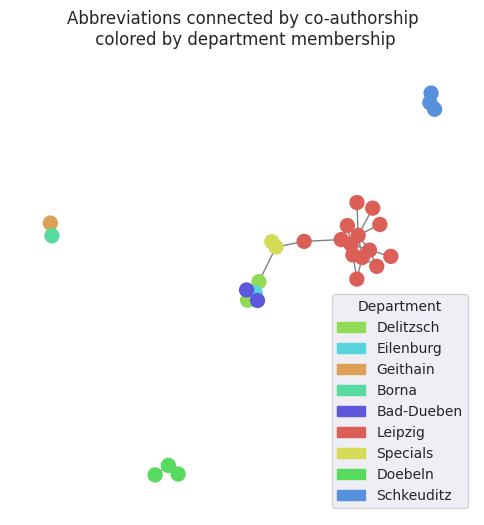

In [29]:
graph = nx.Graph()
graph.clear()

# Count the occurrences of each edge
edge_counts = {}
for edge in edges:
    key = tuple(sorted(edge))
    edge_counts[key] = edge_counts.get(key, 0) + 1

color_map = []

# Add nodes and weighted edges to the graph
for edge, count in edge_counts.items():
    node1, node2 = edge
    if count < 5:
        continue
    if not graph.has_node(node1):
        graph.add_node(node1)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node1].color.values[0])
    if not graph.has_node(node2):
        graph.add_node(node2)
        # add a color to the node
        color_map.append(author_departments[author_departments.name == node2].color.values[0])
    graph.add_edge(node1, node2, weight=count)

# display graph
plt.figure(figsize=[6, 6])
plt.title('Abbreviations connected by co-authorship\n colored by department membership')
nx.draw(graph, node_color=color_map, node_size=100, font_size=6.5, font_weight='bold', edge_color='gray')
# Create a dummy plot for the legend (this won't be visible, but it's necessary to create a legend)
import matplotlib.patches as mpatches
# get department names from author_departments that are in color_map
departments_in_color_map = [author_departments[author_departments.color == color].department.values[0] for color in color_map]
# merge as dict with department name as key and color as value
color_legend_map = dict(zip(departments_in_color_map, color_map))
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in color_legend_map.items()]
plt.legend(handles=legend_patches, title='Department', loc='lower right')
plt.savefig('../reports/figures/department_exploration/abbreviations_co_authors_department_membership.png', dpi=200)